In [ ]:
!pip install findspark
!pip install pyspark
!apt-get install -qq openjdk-17-jdk-headless
from google.colab import drive

Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../openjdk-17-jre-headless_17.0.14+7-1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.14+7-1~22.04.1) ...
Selecting previously unselected package openjdk-17-jdk-headless:amd64.
Preparing to unpack .../openjdk-17-jdk-headless_17.0.14+7-1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jdk-headless:amd64 (17.0.14+7-1~22.04.1) ...
Setting up openjdk-17-jre-headless:amd64 (17.0.14+7-1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/jpackage to provide /usr/bin/jpackage (jpackage) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openj

In [ ]:
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import findspark, os
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IG Calculation") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [ ]:
train = spark.read.parquet("./drive/MyDrive/dataset/train_selected.parquet")
test = spark.read.parquet("./drive/MyDrive/dataset/test_selected.parquet")

In [ ]:
train.groupBy("Accident_Severity_ind").count().orderBy("Accident_Severity_ind").show()

+---------------------+------+
|Accident_Severity_ind| count|
+---------------------+------+
|                  0.0|208826|
|                  1.0| 35039|
|                  2.0|  4692|
+---------------------+------+



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

In [ ]:
##############################################
# DES TREE WITHOUT CLASS BALANCING
#############################################

In [ ]:
# weight class CA

In [ ]:
#total = 208826 + 35039 + 4692 = 248557
#freq = {
#    0.0: 208826 / 248557 ≈ 0.840,
#    1.0: 35039 / 248557 ≈ 0.141,
#    2.0: 4692 / 248557 ≈ 0.019 }
#
#weights = {
#    0.0: 0.019 / 0.840 ≈ 0.023,
#    1.0: 0.019 / 0.141 ≈ 0.135,
#    2.0: 0.019 / 0.019 = 1.0
#}
weights = {0.0: 0.023, 1.0: 0.135, 2.0: 1.0}


In [ ]:
from pyspark.sql.functions import when, col
train = train.withColumn(
    "classWeight",
    when(col("Accident_Severity_ind") == 0.0, weights[0.0])
     .when(col("Accident_Severity_ind") == 1.0, weights[1.0])
     .when(col("Accident_Severity_ind") == 2.0, weights[2.0])
     .otherwise(1.0)
)

In [ ]:
train.show(5)

+---------------------+------------------------------+-----------------+---------------------+------------------------+---------------+----------------------+-----------------------+-----------------------------------------------+-------------------+-------------------------------+---------------------+----------------+----------------+--------------------+------------------------------+-----------------------+----------------------+--------------------+------------------------------+---------------------+-----------+
|Casualty_Severity_ind|Local_Authority_(District)_ind|Casualty_Type_ind|Vehicle_Manoeuvre_ind|Number_of_Casualties_ind|Speed_limit_ind|Casualty_Reference_ind|Urban_or_Rural_Area_ind|Did_Police_Officer_Attend_Scene_of_Accident_ind|Junction_Detail_ind|Vehicle_Leaving_Carriageway_ind|Junction_Location_ind|Vehicle_Type_ind|Police_Force_ind|Junction_Control_ind|Vehicle_Reference_Casualty_ind|1st_Point_of_Impact_ind|Number_of_Vehicles_ind|Light_Conditions_ind|Hit_Object_off_Car

In [ ]:
for column in train.columns:
    n_unique = train.select(column).distinct().count()
    print(f"{column}: {n_unique} unique values")


Casualty_Severity_ind: 3 unique values
Local_Authority_(District)_ind: 416 unique values
Casualty_Type_ind: 21 unique values
Vehicle_Manoeuvre_ind: 18 unique values
Number_of_Casualties_ind: 3 unique values
Speed_limit_ind: 3 unique values
Casualty_Reference_ind: 78 unique values
Urban_or_Rural_Area_ind: 3 unique values
Did_Police_Officer_Attend_Scene_of_Accident_ind: 3 unique values
Junction_Detail_ind: 9 unique values
Vehicle_Leaving_Carriageway_ind: 9 unique values
Junction_Location_ind: 9 unique values
Vehicle_Type_ind: 20 unique values
Police_Force_ind: 51 unique values
Junction_Control_ind: 6 unique values
Vehicle_Reference_Casualty_ind: 65 unique values
1st_Point_of_Impact_ind: 5 unique values
Number_of_Vehicles_ind: 3 unique values
Light_Conditions_ind: 5 unique values
Hit_Object_off_Carriageway_ind: 12 unique values
Accident_Severity_ind: 3 unique values
classWeight: 3 unique values


In [ ]:
##########################################
# delete columns with too many unique values
##########################################

In [ ]:
columns_to_drop = [
    "Local_Authority_(District)_ind",
    "Casualty_Reference_ind",
    "Police_Force_ind",
    "Vehicle_Reference_Casualty_ind"
]

In [ ]:
train = train.drop(*columns_to_drop)
test = test.drop(*columns_to_drop)

In [ ]:
train.write.mode("append").parquet("./drive/MyDrive/dataset/train_selected_tree.parquet")
test.write.mode("append").parquet("./drive/MyDrive/dataset/test_selected_tree.parquet")

In [ ]:
train.printSchema()

root
 |-- Casualty_Severity_ind: double (nullable = true)
 |-- Casualty_Type_ind: double (nullable = true)
 |-- Vehicle_Manoeuvre_ind: double (nullable = true)
 |-- Number_of_Casualties_ind: double (nullable = true)
 |-- Speed_limit_ind: double (nullable = true)
 |-- Urban_or_Rural_Area_ind: double (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident_ind: double (nullable = true)
 |-- Junction_Detail_ind: double (nullable = true)
 |-- Vehicle_Leaving_Carriageway_ind: double (nullable = true)
 |-- Junction_Location_ind: double (nullable = true)
 |-- Vehicle_Type_ind: double (nullable = true)
 |-- Junction_Control_ind: double (nullable = true)
 |-- 1st_Point_of_Impact_ind: double (nullable = true)
 |-- Number_of_Vehicles_ind: double (nullable = true)
 |-- Light_Conditions_ind: double (nullable = true)
 |-- Hit_Object_off_Carriageway_ind: double (nullable = true)
 |-- Accident_Severity_ind: double (nullable = true)
 |-- classWeight: double (nullable = false)



In [ ]:
feature_columns = [col for col in train.columns
                  if col not in ["Accident_Severity_ind", "classWeight"]]

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

In [ ]:
dt = DecisionTreeClassifier(
    labelCol="Accident_Severity_ind",
    featuresCol="features",
    weightCol="classWeight",
    maxDepth=10,
    minInstancesPerNode=20,
    impurity="gini",
    seed=42
)

In [ ]:
pipeline = Pipeline(stages=[assembler, dt])

In [ ]:
model = pipeline.fit(train)

In [ ]:
tree_model = model.stages[-1]
print("depth:", tree_model.depth)
print("numNodes:", tree_model.numNodes)

depth: 10
numNodes: 395


In [ ]:
predictions = model.transform(test)
predictions.select("Accident_Severity_ind", "prediction", "probability").show(5, truncate=False)

+---------------------+----------+-------------+
|Accident_Severity_ind|prediction|probability  |
+---------------------+----------+-------------+
|0.0                  |0.0       |[1.0,0.0,0.0]|
|0.0                  |0.0       |[1.0,0.0,0.0]|
|0.0                  |0.0       |[1.0,0.0,0.0]|
|0.0                  |0.0       |[1.0,0.0,0.0]|
|0.0                  |0.0       |[1.0,0.0,0.0]|
+---------------------+----------+-------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_ind",
    predictionCol="prediction"
)

metrics = {
    "F1-score": "f1",
    "Accuracy": "accuracy",
    "Weighted Precision": "weightedPrecision",
    "Weighted Recall": "weightedRecall"
}

for name, metric in metrics.items():
    score = evaluator.setMetricName(metric).evaluate(predictions)
    print(f"{name}: {score:.4f}")

F1-score: 0.8880
Accuracy: 0.8632
Weighted Precision: 0.9238
Weighted Recall: 0.8632


In [ ]:
#Confusion Matrix
conf_matrix = predictions.crosstab("Accident_Severity_ind", "prediction")
print("Confusion Matrix:")
conf_matrix.show()

Confusion Matrix:
+--------------------------------+------+-----+----+
|Accident_Severity_ind_prediction|   0.0|  1.0| 2.0|
+--------------------------------+------+-----+----+
|                             1.0|  3227|15357|4218|
|                             0.0|123716| 5305|9068|
|                             2.0|   240|  366|2443|
+--------------------------------+------+-----+----+



In [ ]:
#Matthews Correlation Coefficient (MCC)

[MCC](https://miro.medium.com/v2/resize:fit:1400/1*I3dllKdxA0SneUyNr0n75A.png)
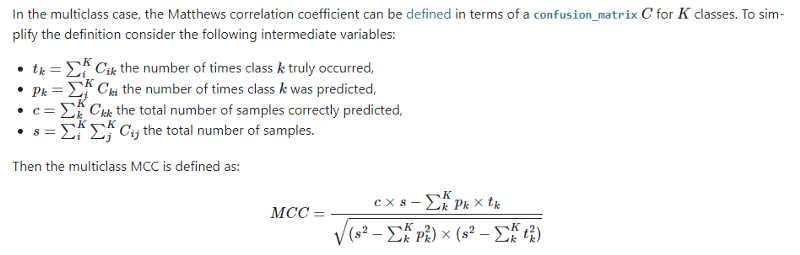

---



In [ ]:
from pyspark.sql.functions import col
import math

# -> float
columns = conf_matrix.columns
label_column = columns[0]
class_labels = [float(c) for c in columns[1:]]  # 0.0, 1.0, 2.0

# rows: (true_label, pred_label, count)
matrix_entries = []
for row in conf_matrix.collect():
    true_label = float(row[label_column])
    for pred_label in class_labels:
        count = int(row[str(pred_label)])
        matrix_entries.append((true_label, pred_label, count))


In [ ]:
# c - total num cor
# p_k - predicted as class k
# t_k - orig class k
# s - total num

from collections import defaultdict

c = 0
p_k = defaultdict(int)
t_k = defaultdict(int)
s = 0

for true_label, pred_label, count in matrix_entries:
    c += count
    p_k[pred_label] += count
    t_k[true_label] += count
    if true_label == pred_label:
        s += count


In [ ]:
sum_pk2 = sum(v**2 for v in p_k.values())
sum_tk2 = sum(v**2 for v in t_k.values())

numerator = c * s - sum(p_k[k] * t_k[k] for k in class_labels)
denominator = math.sqrt((c**2 - sum_pk2) * (c**2 - sum_tk2))

mcc = numerator / denominator if denominator != 0 else 0.0
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.5986
